In [1]:
import os, sys
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
import numpy as np
import matplotlib.pyplot as plt
from backtester.backtester import Backtester
from backtester.strategy import Strategy
from historical_data.yfinance import HistoricalData
import talib as ta

CRYPTO:
stop_loss_multiplier = 10
take_profit_multiplier = 20
longer_ema_offset = 8

FOREX:
stop_loss_multiplier = 2
take_profit_multiplier = 8
longer_ema_offset = 0

In [72]:
asset = "BTC-USD"
short_start = '2024-11-26'
short_end = '2024-12-22'
short_interval = '15m'

In [105]:
# short_period = 12
# long_period = 26
# longer_period = 200
# atr_period = 14
# commission_percentage = 0.001
# stop_loss_multiplier = 10
# take_profit_multiplier = 20
# amount_invested = 1000
# leverage = 10
# longer_ema_offset = 8

asset = "MSTR"
short_start = '2024-01-01'
short_end = '2024-12-29'
short_interval = '1h'

short_period = 12
long_period = 26
longer_period = 200
atr_period = 14
commission_percentage = 0.00
stop_loss_multiplier = 10
take_profit_multiplier = 20
amount_invested = 1000
leverage = 1
longer_ema_offset = 0
portfolio_allocation_ratio = 0.1

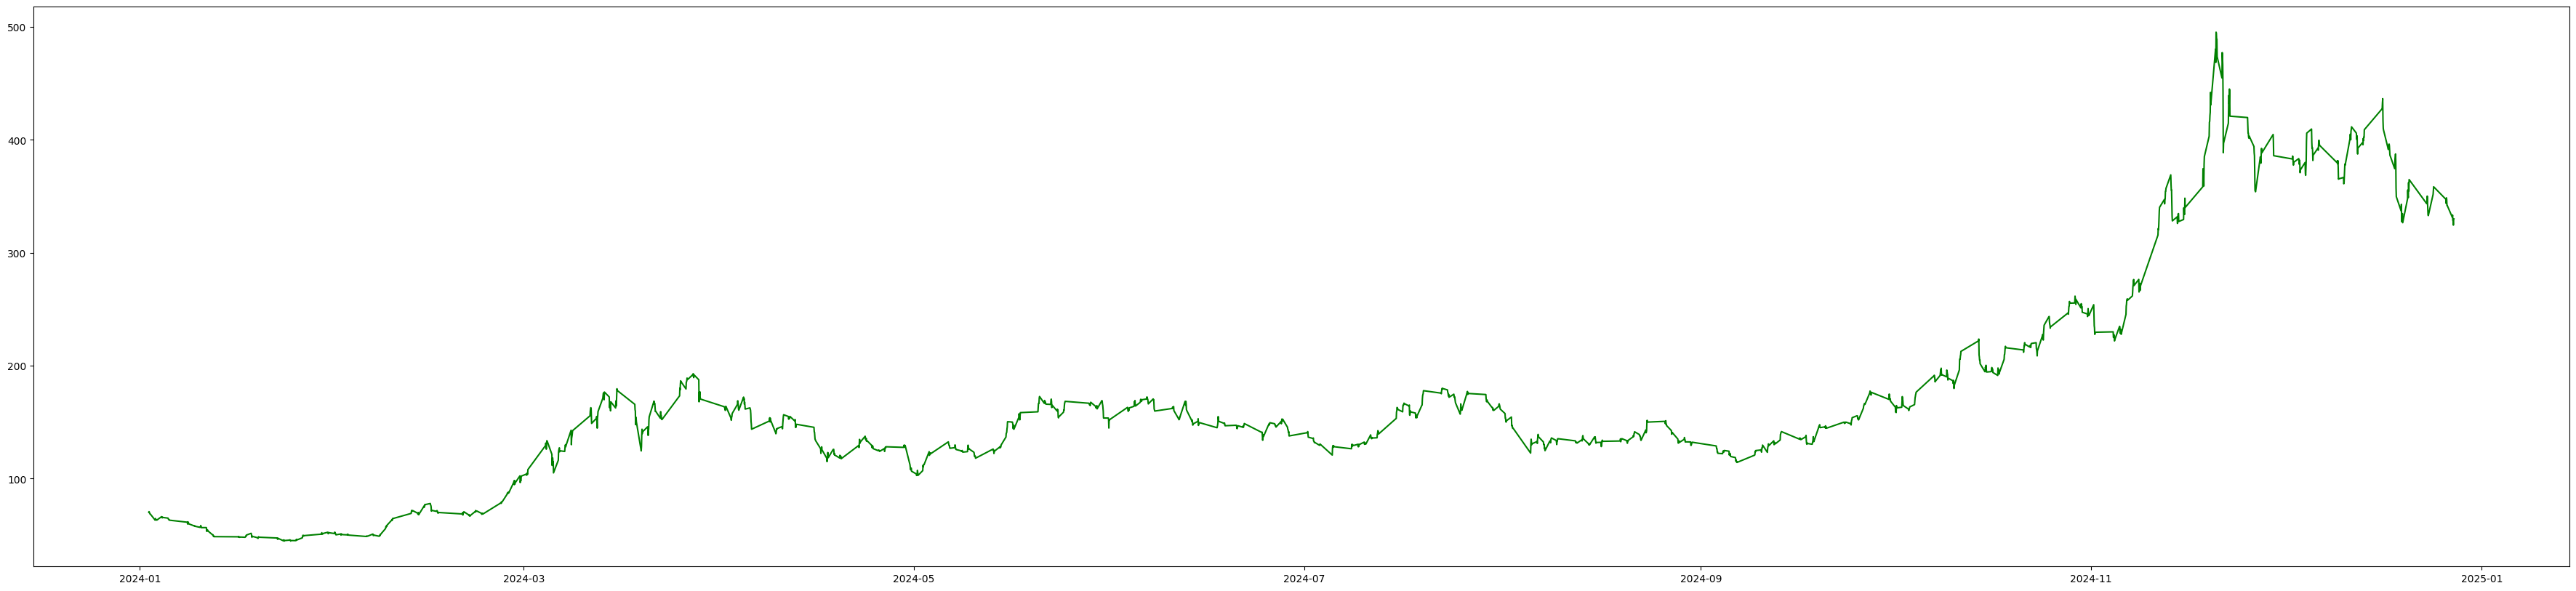

In [106]:
short_historical_data = HistoricalData(asset, short_start, short_end, short_interval)
short_data = short_historical_data.get_data()
short_historical_data.plot_data()

In [107]:
class EMACrossoverLongStrategy(Strategy):
    def __init__(self, data):
        super().__init__(data)
        self.data['Short EMA'] = ta.EMA(self.data['Close'], short_period)
        self.data['Long EMA'] = ta.EMA(self.data['Close'], long_period)
        self.data['ATR'] = ta.ATR(self.data.High, self.data.Low, self.data.Close, atr_period) # ATR is used for setting stop loss
        self.data['Longer EMA'] = ta.SMA(self.data['Close'], longer_period) + (longer_ema_offset*self.data['ATR'])
        self.data['Previous Short EMA'] = self.data['Short EMA'].shift()
        self.data['Previous Long EMA'] = self.data['Long EMA'].shift()
        self.data['Previous Longer EMA'] = self.data['Longer EMA'].shift()
        self.data['Previous Close'] = self.data['Close'].shift()
        self.data = self.data.dropna()
             
    def implement(self):
        self.data['Signal'] = 0
        self.data['Position'] = 0
        position_checker = (self.data['Short EMA'] > self.data['Long EMA']) & \
            (self.data['Previous Short EMA'] <= self.data['Previous Long EMA']) & \
            (self.data['Close'] > self.data['Longer EMA'])
        self.data['Position'] = np.where(position_checker, 1,
                                np.where(((self.data['Short EMA'] < self.data['Long EMA']) & \
                                    (self.data['Previous Short EMA'] >= self.data['Previous Long EMA'])), -1, 0))

        for i in self.data.index:
            if self.position == 'close':
                if self.data.at[i, 'Position'] == 1:
                    buy_price = self.data['Close'][i]
                    stop_loss = buy_price - (stop_loss_multiplier * self.data.at[i, 'ATR'])
                    take_profit = buy_price + (take_profit_multiplier * self.data.at[i, 'ATR'])
                    self.position = 'buy'
                    self.buy_trade(i, stop_loss=stop_loss, take_profit=take_profit)
                    self.data.at[i, 'Signal'] = 1
            else:            
                if (self.data.at[i, 'Close'] <= self.stop_loss) | (self.data.at[i, 'Close'] >= self.take_profit):
                    self.close_trade(i)
                    self.data.at[i, 'Signal'] = 0
                    self.position = 'close'
                else:
                    self.data.at[i, 'Signal'] = 1

    def plot_indicators(self):
        _, axis = plt.subplots(2, sharex=True, figsize=(45, 25))
        axis[0].set_title("Close Price Series with Crossovers") 
        axis[0].plot(self.data.index, self.data['Short EMA'], color='blue')
        axis[0].plot(self.data.index, self.data['Long EMA'], color='green')
        axis[0].plot(self.data.index, self.data['Longer EMA'], color='black')
        axis[0].grid()
        axis[1].set_title("ATR") 
        axis[1].plot(self.data.index, self.data['ATR'], color='red')
        axis[1].grid()
        plt.show()

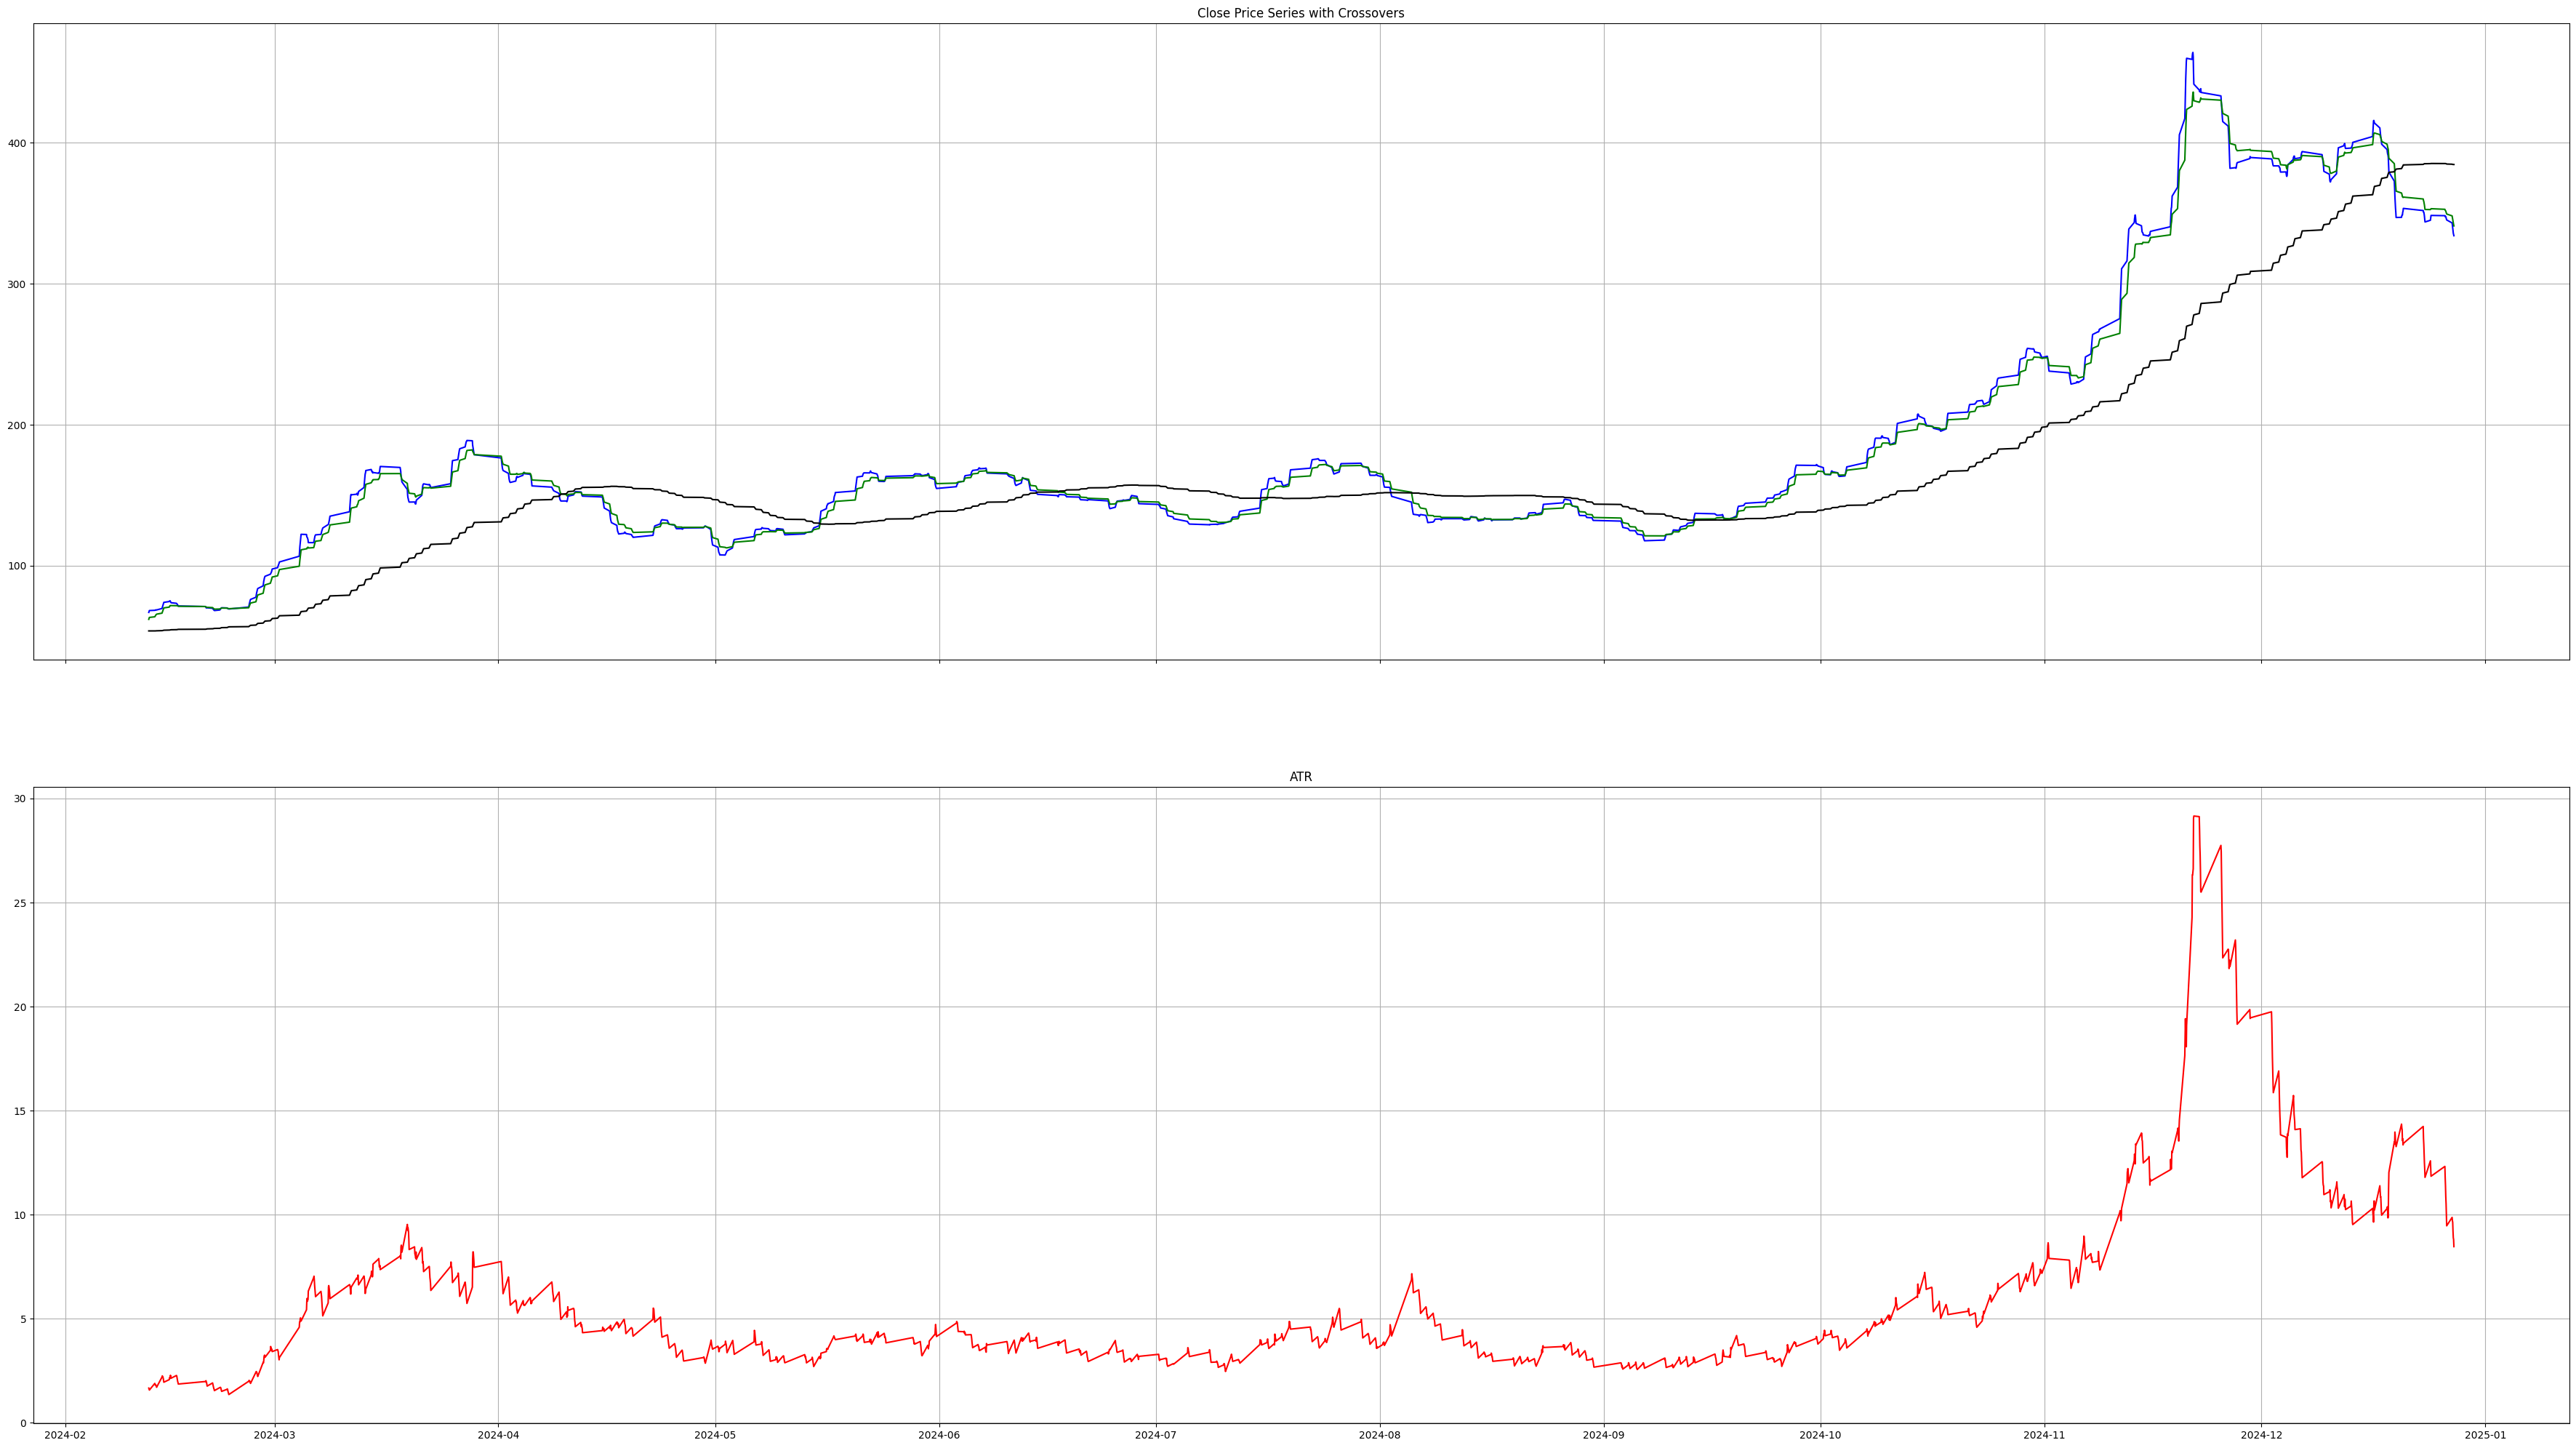

In [108]:
emaCrossover = EMACrossoverLongStrategy(data=short_data)
emaCrossover.plot_indicators()

/var/folders/9x/c8rnngl93m162n92399m4b6w0000gn/T/ipykernel_27588/2706193754.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Signal'] = 0
/var/folders/9x/c8rnngl93m162n92399m4b6w0000gn/T/ipykernel_27588/2706193754.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Position'] = 0
/var/folders/9x/c8rnngl93m162n92399m4b6w0000gn/T/ipykernel_27588/2706193754.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

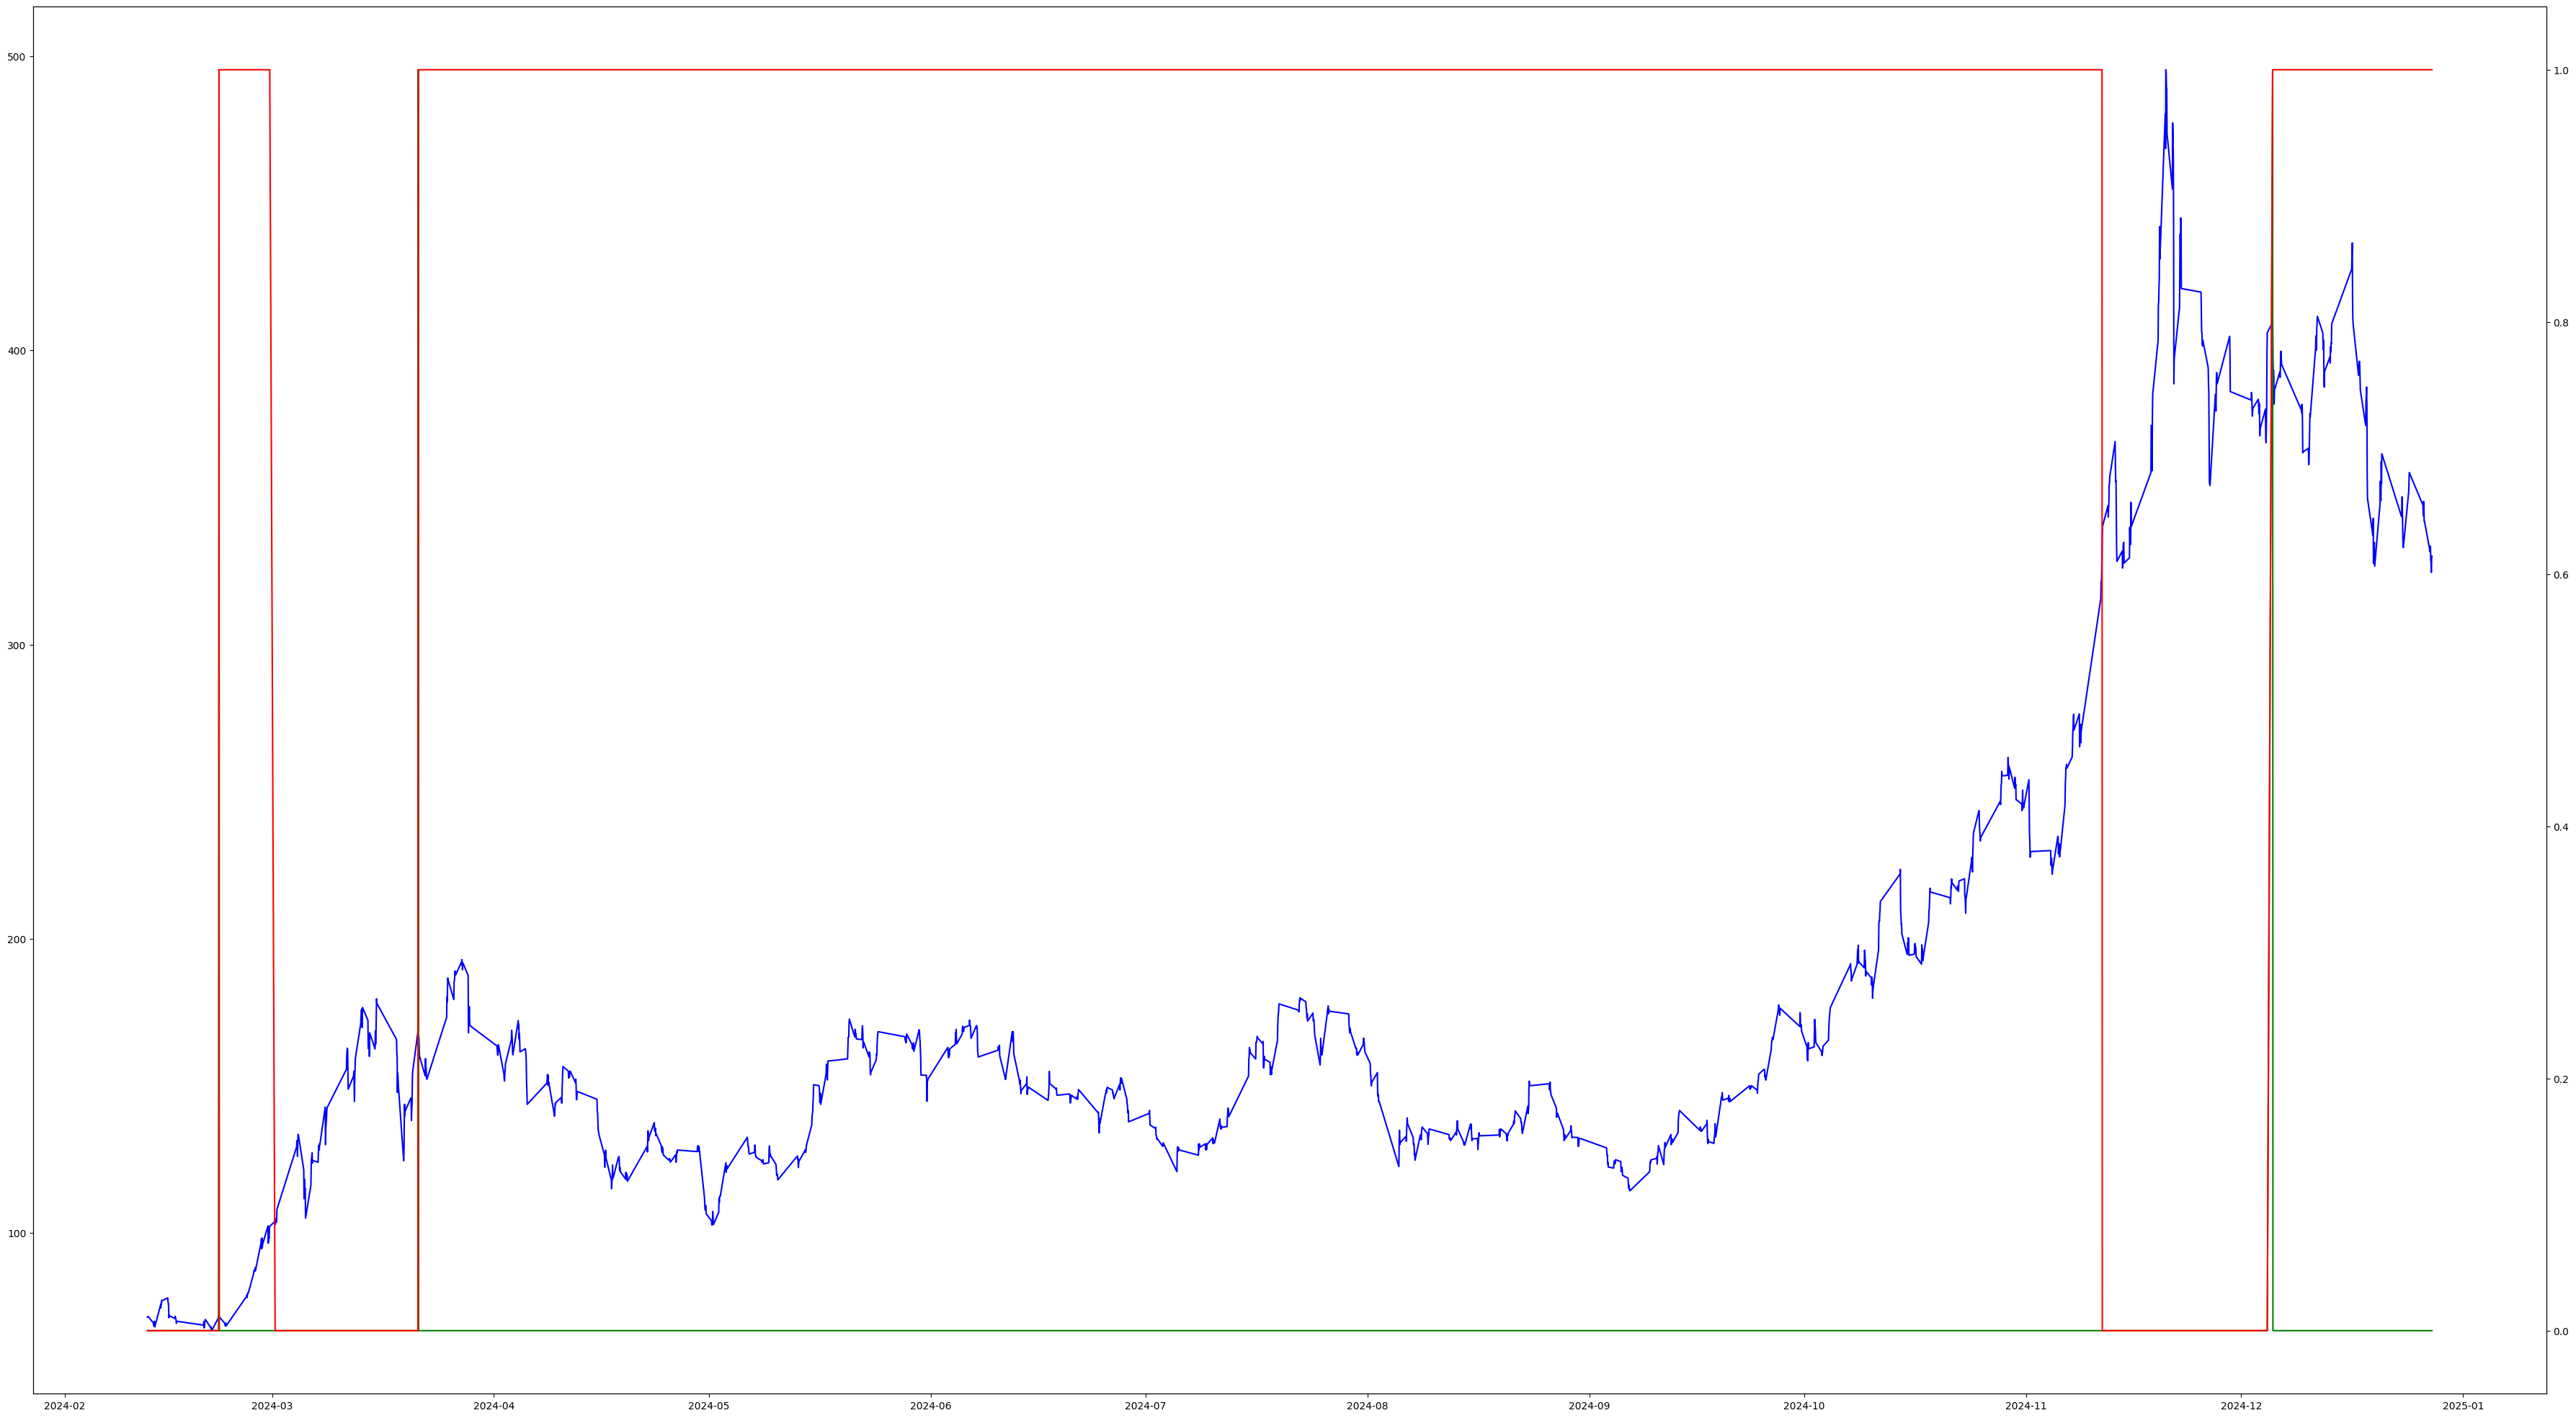

In [109]:
emaCrossover.implement()
emaCrossover.plot_positions()

/Users/snehil1998/Documents/Repos/trading-strategies/backtester/backtester.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1001.191066357107' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.data.at[i, 'Cumulative Strategy Returns'] = cash


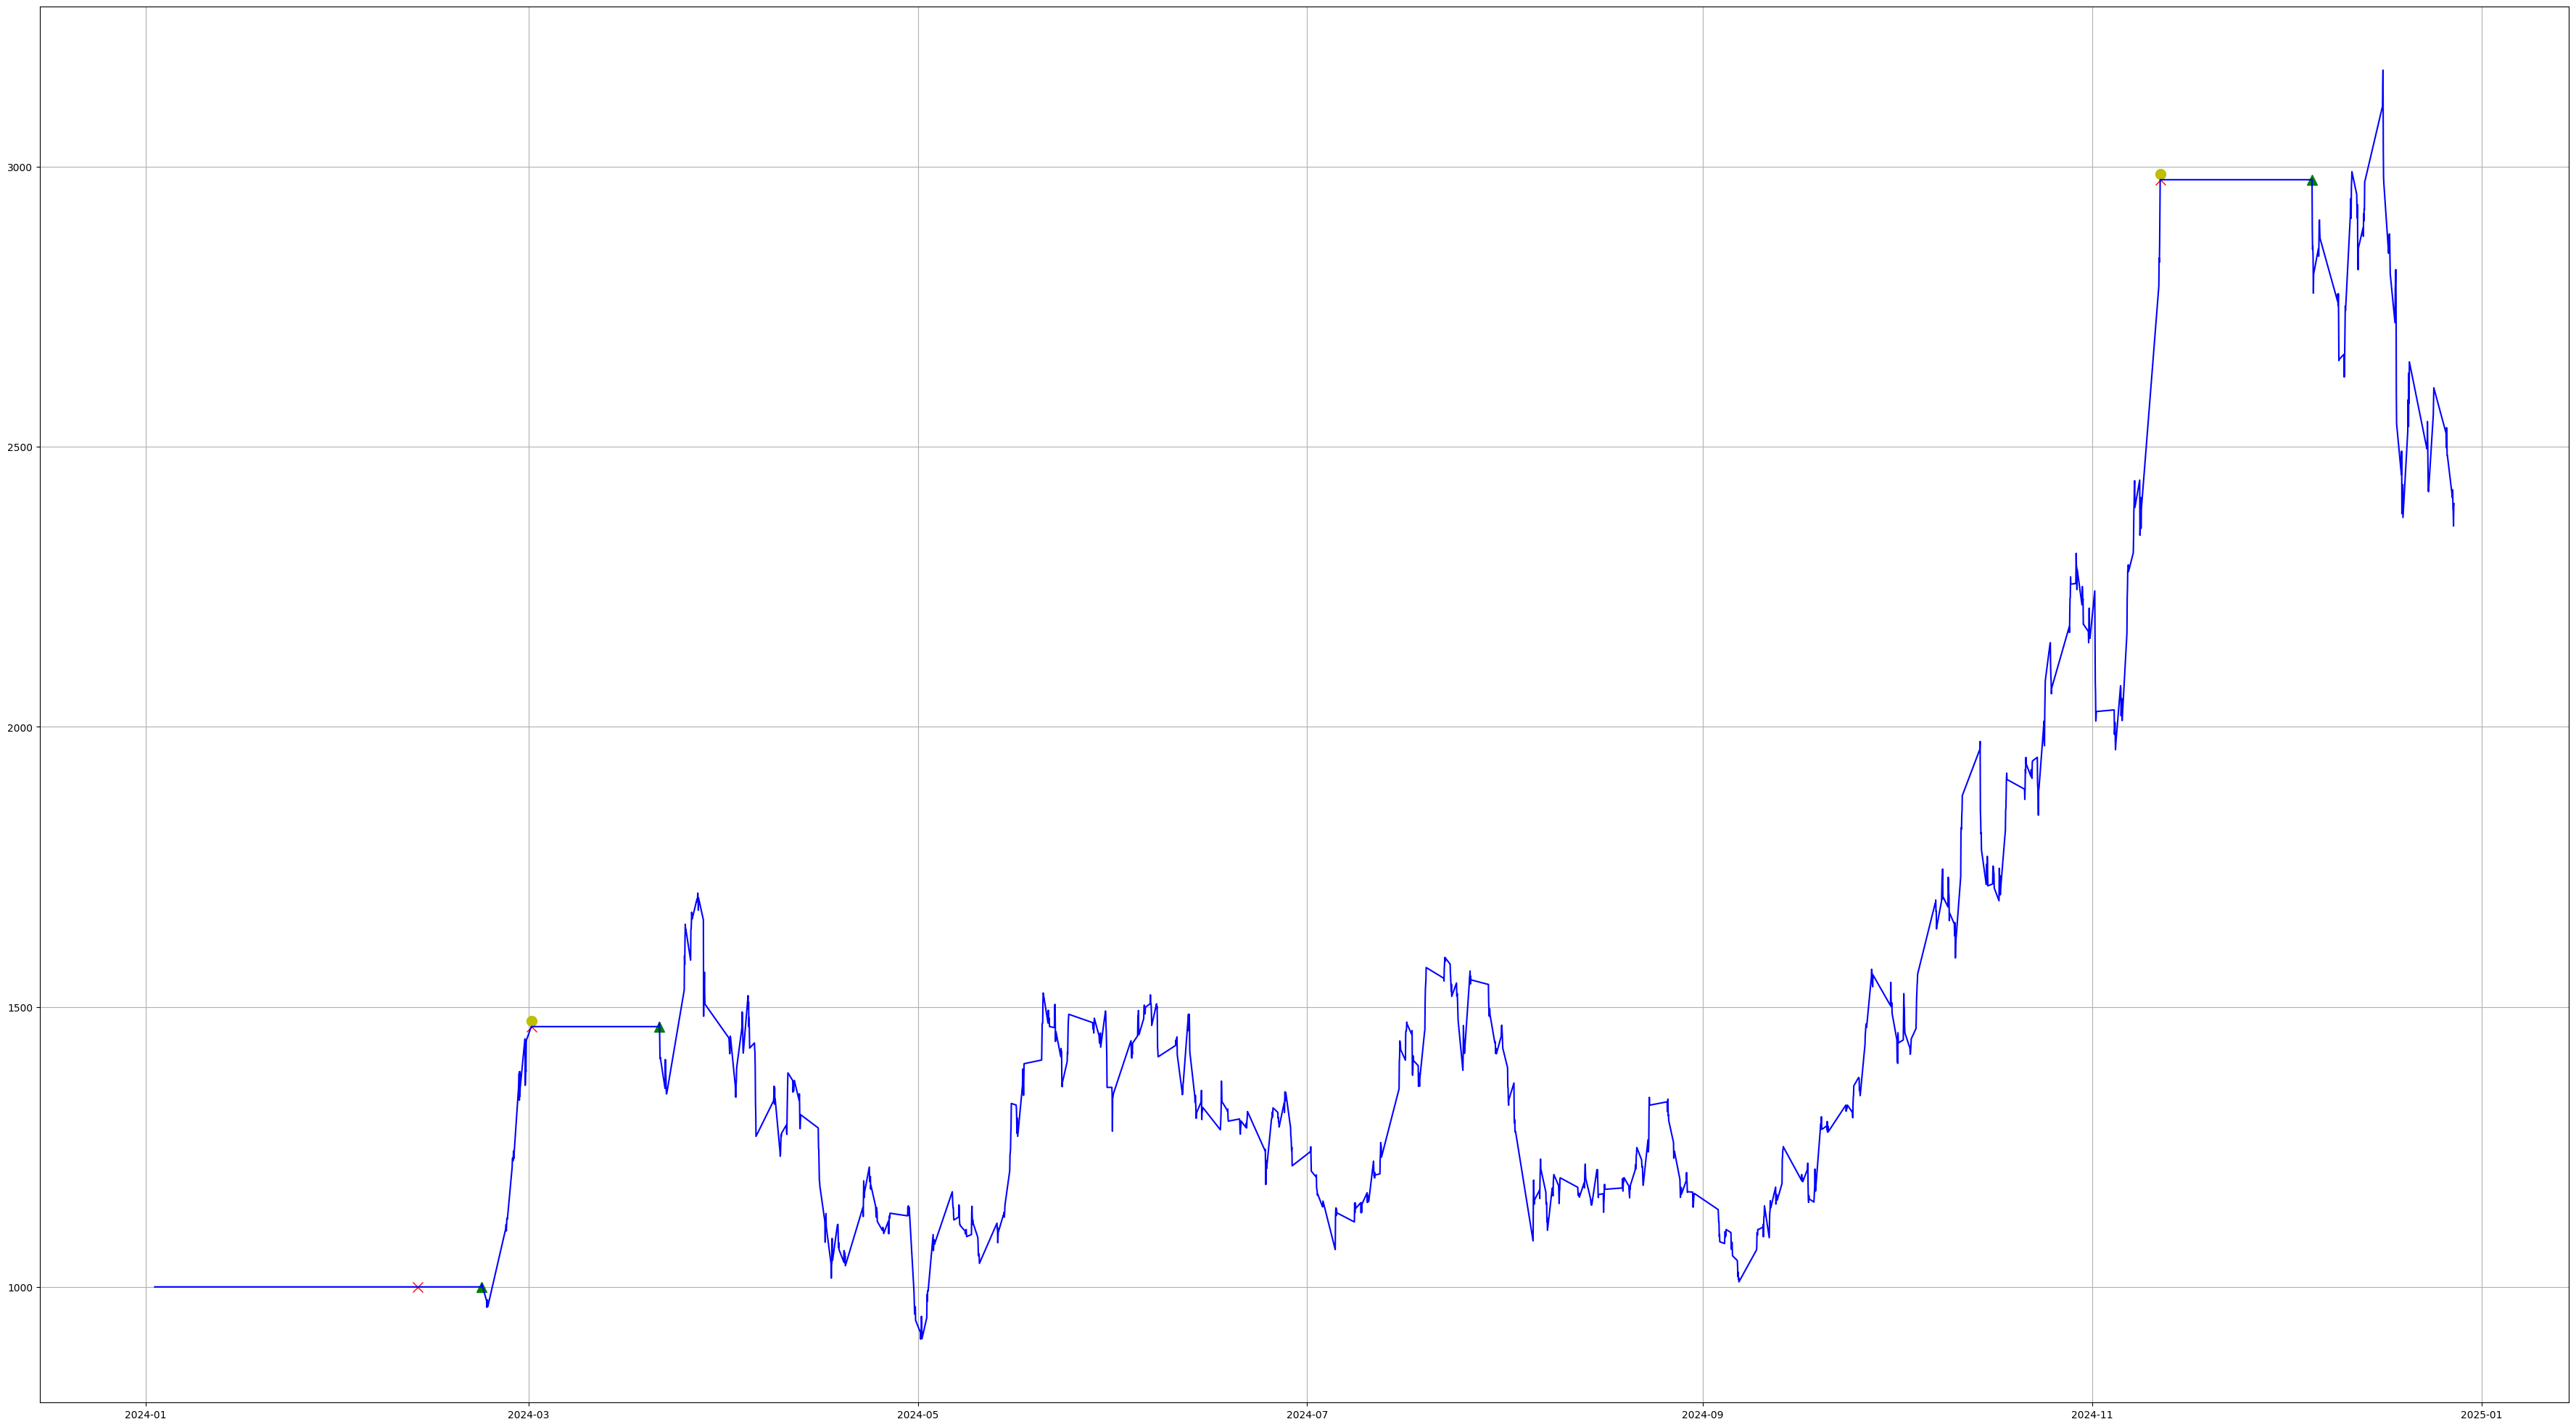

In [110]:
backtester = Backtester(emaCrossover, short_data, trade_commission=commission_percentage, amount_invested=amount_invested, leverage_ratio=leverage)
backtester.backtest()
backtester.plot_backtest()

In [111]:
backtester.get_metrics()

Final value:  2398.3992215962453
P&L:  1398.3992215962453
Returns %:  139.8399221596245
Number of trades:  2
Loss trades %:  0.0
Profit trades %:  100.0
Annual Sharpe ratio:  2.7716992278602026
Max profit %:  217.24273958992546
Max loss %:  -9.321156246125451


/Users/snehil1998/Documents/Repos/trading-strategies/backtester/backtester.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Final value: ', self.data['Cumulative Strategy Returns'][-1])
/Users/snehil1998/Documents/Repos/trading-strategies/backtester/backtester.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('P&L: ', (self.data['Cumulative Strategy Returns'][-1] - (self.leverage_ratio*self.amount_invested)))
/Users/snehil1998/Documents/Repos/trading-strategies/backtester/backtester.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys